# Project Proposal: Predicting and Exploring Heart Disease through Cholesterol, Blood Pressure, Blood Sugar and Age 
#### By Marius Shepherd, Sarenna Ulman, Hayden Hong, Baray Sidhu

## Introduction


We are trying to answer the question:
- Is it possible to predict the result of a heart disease diagnosis of a patient based on a patient's cholesterol levels, blood sugar levels, blood pressure and age through classification with regression? 

We will be using the Heart Disease dataset from UCI, linked here:
https://archive.ics.uci.edu/ml/datasets/Heart+Disease
Specifically, we used the Cleveland Processed Data,
https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data

This dataset was taken from the UCI machine learning repository, specifically the Cleveland dataset which takes data of patients from Long Beach and Cleveland Clinic Foundation, taken in 1988.

The dataset contains data regarding heart disease patients and relavant information such as sex, age, cholesterol, max heart rate and more. Other columns include more technical terms, but many we will not be using as predictors. More information on our predictors will follow.

Heart disease refers to several types of heart related sicknesses such as heart attacks, unstable angina and may more. This data set categorizes the result of the patient's diagnosis to 4 types of categories: typical angina, atypical angina, non-anginal pain, and asymptomatic. We will be generalizing this to presence and absence of heart disease, asymptomatic being absence and the rest being presence of heart disease.

Our variables of interest:
- age: age of the patient recorded
- cholesterol: Serum cholesterol, or total cholesterol recorded in mg/dl in each patient
- fbs: fasting blood sugar, level of sugar (glucose) in blood after a fasting period
- rbp: resting blood pressure, blood pressure of patient at rest
- num: the result of diagnosis for heart disease, we will categorize 0 to be absence and 1-4 to be presence, ignoring the stage and severity of the heart disease.

## Preliminary exploratory data analysis:

In [78]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
options(repr.matrix.max.rows = 6)

### Cleaning and Reading the Data

We will be cleaning and wrangling the data by changing column names, categorizing heart disease to be absence or presence and filter any unknown values that are represented by "?", as this may cause issues later when creating a model.

In [79]:
# reading the data, it does not have column names
heart_disease <- read_csv(url("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"),
                         col_names = FALSE)

# labelling columns, which are absent in the original dataset
colnames(heart_disease) <- c("age", "sex", "chest_pain_type", "rbp", "cholesterol", 
                      "fbs", "rer",
                      "max_heart_rate","eia", "STdep",
                      "slope","ca", "thal", "num")

# choosing only relevant predictors
heart_disease <- heart_disease |> select(age, rbp, cholesterol, fbs, num)

# filter when data is unknown (the website tells us there are some unknown values, and they are labelled with "?")
heart_disease <- heart_disease |> filter(age != "?")
heart_disease <- heart_disease |> filter(rbp != "?")
heart_disease <- heart_disease |> filter(age != "?")
heart_disease <- heart_disease |> filter(cholesterol != "?")
heart_disease <- heart_disease |> filter(num != "?")

# changing categorical data to factors, such as fbs which is either 0 or 1.
heart_disease <- heart_disease |> 
        mutate(fbs = as_factor(fbs), num = as_factor(num))

# renaming heart disease categories to absence or presence. This simplifies the training process.
heart_disease <- heart_disease |>
             mutate(num = case_when(num == 0 ~ "absence", 
                                    num == 1 ~ "presence",
                                    num == 2 ~ "presence",
                                    num == 3 ~ "presence",
                                    num == 4 ~ "presence"))
# renaming blood sugar greater than 120 mg/dl as yes, otherwise no. This makes plotting and visulization more clear
heart_disease <- heart_disease |>
             mutate(fbs = case_when(fbs == 0 ~ "no", 
                                    fbs == 1 ~ "yes"))


heart_disease



Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,rbp,cholesterol,fbs,num
<dbl>,<dbl>,<dbl>,<chr>,<chr>
63,145,233,yes,absence
67,160,286,no,presence
67,120,229,no,presence
⋮,⋮,⋮,⋮,⋮
57,130,131,no,presence
57,130,236,no,presence
38,138,175,no,absence


In [80]:
# Splitting the data, we will be splitting to 75% and 25%, with strata = num to keep the distribution consistent
set.seed(1)
# we set seed to keep this consistent when others run it
heart_split <- initial_split(heart_disease, prop = 0.75, strata = num)
heart_train <- training(heart_split)
# will not be used
heart_test <- testing(heart_split)

### Analysis via Summarizing
The table summarizes the average of age, which can tell us that the age distribution is reasonably around 54. This helps us know that the dataset is a good representation of heart disease patients in terms of age. 

We have also averaged the predictors such as average cholesterol, average resting blood pressure, and counted the number of patients with heart disease. This gives us insight in how it compares with actual averages in real life. For example, average serum cholesterol is around 200 to 240 mg/dl (milligrams per deciliter), which show that this dataset and higher than average serum cholesterol in their blood. With regards to resting blood pressure, which the dataset most likely refer to the upper number, is 131 mm Hg (millimeters mercury). This is slightly higher than the safe level, almost to hypertension level (dangerous). The number of patients with blood sugar over 120 mg/dl is 34 out of 227 observations. Blood sugar level over 120 mg/dl is diabetes, which we expect to contribute to heart disease. We see that there are not too many diabetic patients in the whole dataset.

In [81]:
## Table of data analysis

# Getting the mean of the age 
average_age <- heart_train |> summarise(mean(age))

# Number of observations of patients (number of patients/data) in the training set
num_obs <- tibble(nrow(heart_train))

# average of serum cholesterol, which is total cholesterol in body, used as a predictor
avg_chol <- heart_train |> summarise(mean(cholesterol))


# number of patients with fasting blood sugar greater than 120 mg/dl
with_fbs <- heart_train |> filter(fbs == "yes")
num_fbs <- tibble(nrow(with_fbs))


# average of resting blood pressure 
avg_rbp <- heart_train |> summarise(mean(rbp))

# number of people with heart disease (any type) 
num_presence <- heart_train |> filter(num == "presence")
num_hd <- tibble(nrow(num_presence))

# putting together to one table
data_analysis <- bind_cols(num_obs, average_age, avg_chol, avg_rbp, num_fbs, num_hd)

colnames(data_analysis)  <- c("Number of Observations (Patients)", "Average Age", "Average Serum Cholesterol in mg/dl", "Average Resting Blood Pressure (mmHg), High", "Number of Patients with Blood Sugar > 120 mg/dl", "Number of Patients with Diagnosed Heart Disease")

data_analysis


Number of Observations (Patients),Average Age,Average Serum Cholesterol in mg/dl,"Average Resting Blood Pressure (mmHg), High",Number of Patients with Blood Sugar > 120 mg/dl,Number of Patients with Diagnosed Heart Disease
<int>,<dbl>,<dbl>,<dbl>,<int>,<int>
227,54.9207,246.9604,132.7709,33,104


### Visualization

The first plot is a bar chart that shows the distribution of high blood sugar and if they have heart disease or not. This shows that There was a higher percentage presence of heart disease for patients with high blood sugar, which the next plot also describes.

The second plot is a boxplot showing the distribution of cholesterol for patients with or without blood sugar levels over 120 mg/dl. It is grouped with the heart disease presence or absence, and it shows that people with higher blood sugar had more cholesterol, and people with heart disease also had higher medians of cholesterol, which points to them being good predictors of heart disease as there is a correlation that can be inferred. 


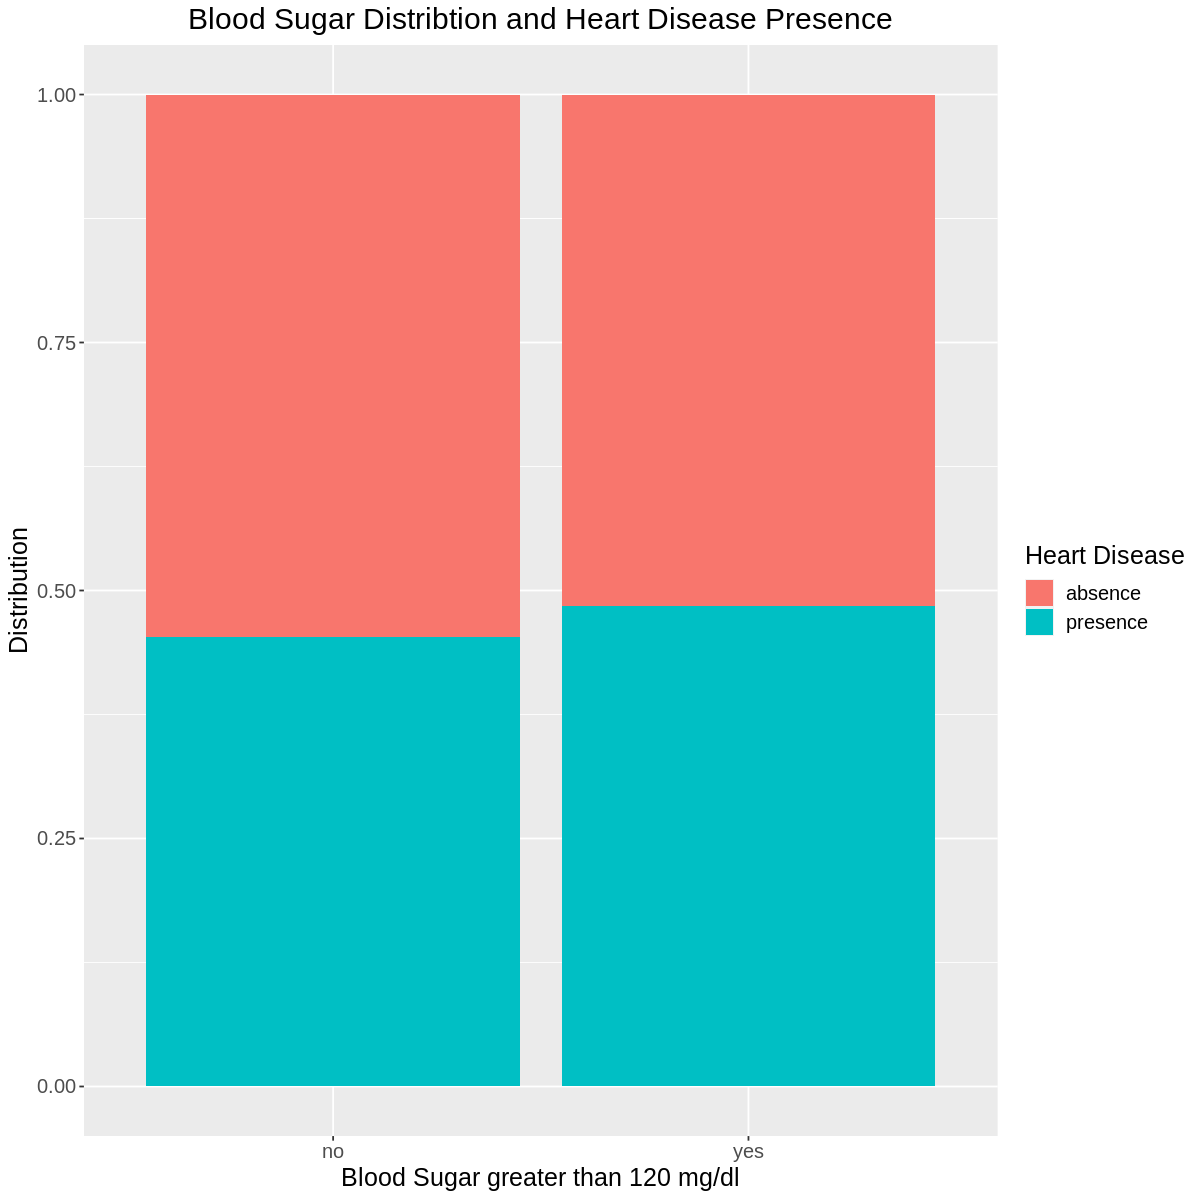

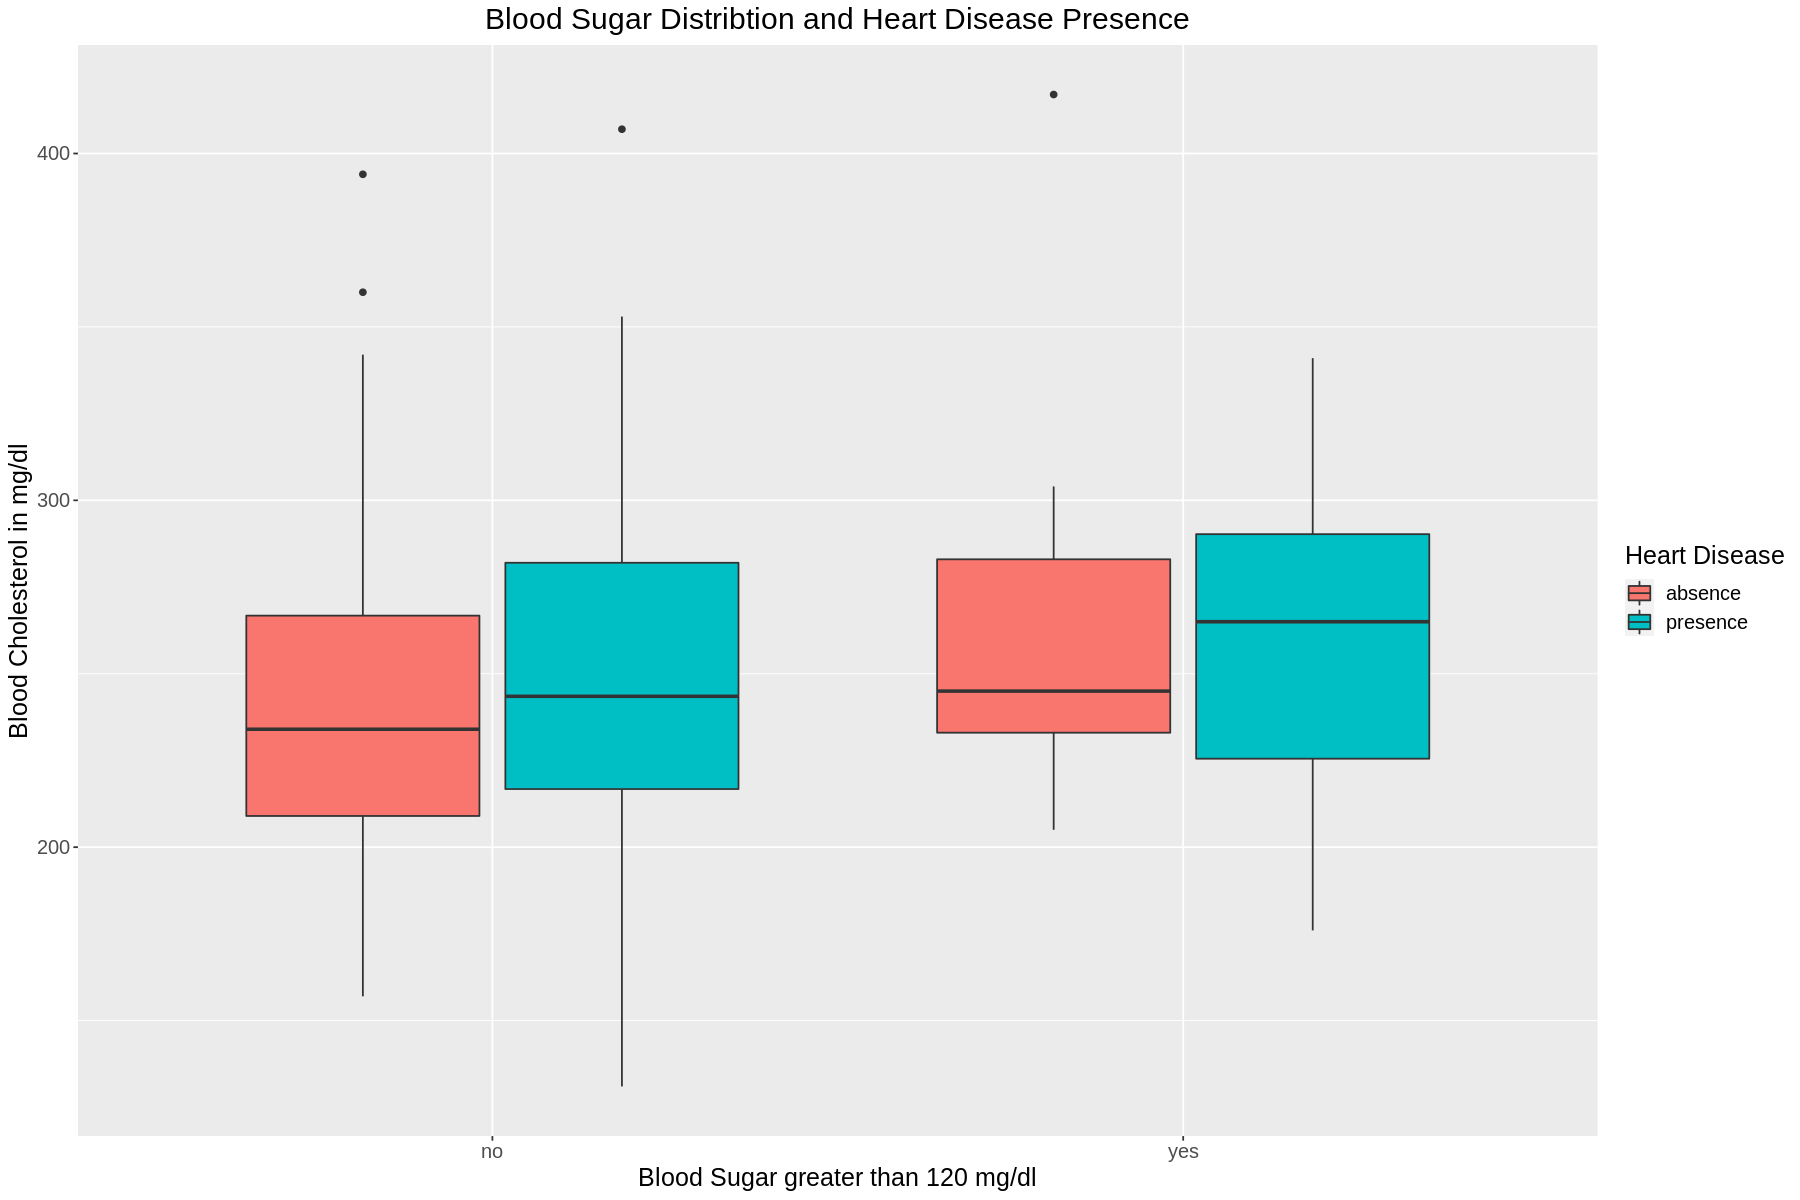

In [82]:
# plotting for data analysis
options(repr.plot.width = 10, repr.plot.height = 10) 

cholesterol_plot <- heart_train |> ggplot(aes(x= fbs, fill = num)) + geom_bar(position = "fill") + 
            labs(x= "Blood Sugar greater than 120 mg/dl", y="Distribution", fill ="Heart Disease") +
            ggtitle("Blood Sugar Distribtion and Heart Disease Presence") +
            theme(text=element_text(size=15)) +
            theme(plot.title = element_text(hjust = 0.5))
cholesterol_plot

options(repr.plot.width = 15, repr.plot.height = 10) 

blood_sugar_plot <- heart_train |> ggplot(aes(x= fbs, y = cholesterol, fill = num)) + geom_boxplot() + 
            labs(x= "Blood Sugar greater than 120 mg/dl", y="Blood Cholesterol in mg/dl", fill ="Heart Disease") +
            ggtitle("Blood Sugar Distribtion and Heart Disease Presence") +
            theme(text=element_text(size=15)) +
            theme(plot.title = element_text(hjust = 0.5))
blood_sugar_plot


## Methods

We will be using age, fasting blood sugar, resting heart rate and cholesterol levels as predictors for our data analysis. We can visualize the results of using a classification model by getting the accuracy using collect_metrics and the confusion matrix to asses our model, or plotting our predictors with each other to see a correlation. This can be plotted to further visualize our accuracy results. We will also use regression to predict whether or not new patients will develop heart disease based on their age, blood pressure, etc. We will plot these patients' data on our graphs as well and show their "k-nearest neighbors" function.  

Predictors:

Age:
	According to the National Institute on Aging, individuals that are older have a higher likelihood of having heart disease. This is the case as there is an “increased stiffness of large arteries” that contributes to the “buildup of fatty deposits in the walls of arteries.”

https://www.nia.nih.gov/health/heart-health-and-aging

Fasting Blood Sugar (Diabetes):
	Having a higher fasting blood sugar level is an indicator for diabetes. According to the Centers for Disease Control and Prevention, having diabetes “can damage blood vessels and the nerves that control your heart.” Our visualization, specifcally the boxplot supports this.

https://www.cdc.gov/diabetes/library/features/diabetes-and-heart.html#:~:text=Over%20time%2C%20high%20blood%20sugar,and%20can%20damage%20artery%20walls.


Cholesterol: 
	According to clevelandclinic, cholesterol “leads to a buildup of plaque inside your blood vessels”. This buildup of plaque then “limits how much blood can flow,” thus, causing heart disease as well as other medical conditions. Our visualizations also support this.
	
https://my.clevelandclinic.org/health/articles/11918-cholesterol-high-cholesterol-diseases

Resting Blood Pressure:
	According to the Centers for Disease Control and Prevention, having a higher resting blood pressure can “damage arteries by making them less elastic.” This leads to being less blood flow to the heart.

https://www.cdc.gov/bloodpressure/about.htm#:~:text=High%20blood%20pressure%20can%20damage%20your%20arteries%20by%20making%20them,Chest%20pain%2C%20also%20called%20angina.


## Expected outcomes and significance:

We expect to whether or not we can accurately predict heart disease thorugh 4 criteria that we have mentioned, and if it can be implemented in real life as diagnosis for patients by measuring their predictors. We expect specific predictors to have higher affect on the possibility of getting heart disease, and this can impact the way each disgnosis for heart disease is treated: if cholesterol turns out to have limited affect on the possibility of heart disease, it may not be considered as much of an important factor to diagnose heart disease. If we are able to create an model that is very accurately able to predict heart disease just out of these predictors, the benefit can be immense to quickly diagnose patients before their heart disease develops to a dangerous level.This could lead to furture questions like how and why does the specific predictors have more impact than others? What other predictors could have been better to train the model? What other ways can we increase the accuracy of the model?

